<a href="https://colab.research.google.com/github/chrisamz/142-Final-Project/blob/main/mysol_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
#import mcmc

In [64]:
def particle_gibbs(V,N,eps,delta=1,x0=None,hbar=1,m=1):
    """ Yeilds values of a sequence generated by Gibbs sampling on the
    heat-bath quantum particle.

    V           function of potential energy
    N           number of substeps
    eps         size of substeps
    
    delta       length of interval for the monte carlo walk step (default: 1)
    x0          initial position, length N array, excluding the x_N = x_0 point
                (default: array of zeros)
    hbar        value of h-bar (default: 1)
    m           value of mass (default: 1)
    """
    if x0 is None:
        x0 = np.zeros(N)
    
    stepdim = 0 # which dimension to sample from next

    tau = N*eps
    const_ke_coeff = m/(2*N*eps**2) #constant in front of the KE sum
    const_pe_coeff = 1/N            #constant in front of the PE sum


    E_old = (
        #KE - use average displacement (wrap around since motion periodic)
        const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
        #PE - use each point
       +const_pe_coeff*sum(V(x0))
    )

    num_iters = 0
    num_accepts = 0

    while True:
        num_iters += 1
        #new point only along specific dimension
        xold = x0[stepdim]
        xnew = xold + (np.random.rand() - 0.5)*delta
        xleft = x0[(stepdim-1) % N]
        xright = x0[(stepdim+1) % N]
        #subtract old terms and add new terms inside exp
        # E_new = E_old + (
        #     const_ke_coeff*((xnew - xleft)**2 - (xold - xleft)**2
        #         + (xright - xnew)**2 - (xright - xold)**2 )
        #    +const_pe_coeff*(V(xnew) - V(xold))
        # )
        x0[stepdim] = xnew
        #E_new = (
        #    #KE - use average displacement (wrap around since motion periodic)
        #    const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
        #    #PE - use each point
        #    +const_pe_coeff*sum(V(x0))
        #)
        KEnew = const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
        PEnew = const_pe_coeff*sum(V(x0))
        E_new = KEnew + PEnew

        x0[stepdim] = xold
        # Pnew/Pold = exp(-tau Enew/hbar)/exp(-tau Eold/hbar) = ...
        #print("\n%10.5e" % np.exp(tau/hbar*(E_old - E_new)),end=", ")
        #if np.random.rand() < np.exp(tau/hbar*(E_old - E_new)):
        pold = np.exp(-tau*E_old/hbar)
        pnew = np.exp(-tau*E_new/hbar)
        if pnew > pold or np.random.rand() < pnew/pold:
            x0[stepdim] = xnew
            E_old = E_new
            num_accepts += 1

        #     print("ACCEPT",end=", \n")
        # else:
        #     print("reject",end=", \n")
        yield x0,E_old,stepdim,x0[stepdim],num_accepts/num_iters,KEnew,PEnew
        stepdim = (stepdim + 1) % N


#V = lambda x: -5*x**2 + 0.15 *x**4 # from rogers-rae problem
#V = lambda x: (x**2 - 2)**2
V = lambda x: x**2/2

#parameters
tau = 10
N = 100; eps = tau/ N
#N = 1000; eps = 1
#tau = N * eps
print(tau)

delta = 2 * np.sqrt(eps)

#how many samples to iterate, but throw away
warm_up = 10000

#number of samples to collect
collect_samples = 1000

#number of samples taken per one used
collect_interval = N


#keep energy values for each collection (don't store position values)
E_collect = np.empty(collect_samples)
E_avg = 0

KE_avg = 0; PE_avg = 0

x2_collect = np.empty(collect_samples)
x2_avg2 = 0

#collect x in bins
xmin = -4; xmax = 4; nbins = 100
bindx = (xmax - xmin)/nbins
X_binned = np.zeros(nbins,np.int64)


#=====progress bar
progress_bar_num_parts = 100
print("Progress\n┌" + "─"*progress_bar_num_parts + "┐\n",end="│")
progress_bar_it = 0
#=================

#current sample
n = -warm_up
collect_wait = 0
for x,E,stepdim,xnew,accept_rate,KE,PE in particle_gibbs(V,N,eps,delta=delta,x0=np.zeros(N)):
    if n < 0: #still in warm up
        n += 1
        continue
    #x is returned by reference, don't modify it because it is still in use
    
    #print("%.5f" % accept_rate,E,end="")
    if xmin <= xnew and xnew <= xmax:
        X_binned[int(np.floor((xnew-xmin)/bindx))] += 1
    

    collect_wait += 1
    if collect_wait > collect_interval:
        collect_wait = 0
        n += 1
        # avg = sum_{k=1}^n (val_k)/n = sum_{k=1}^{n-1} (val_k)/n + val_n/n
        #     = old_avg*(n-1)/n + val_n/n
        E_avg = (E_avg*(n-1) + E)/n
        #PE = sum(V(x))/N

        KE_avg = (KE_avg * (n-1) + KE) /n
        
        #KE_avg = (KE_avg*(n-1) + E - PE)/n
        PE_avg = (PE_avg*(n-1) + PE)/n
        x2_avg = (x2_avg*(n-1) + np.mean(x**2)**2)/n

        #collect energy
        E_collect[n-1] = E

        #calculate avg x^2
        x2sum = [x[i]**2 for i in range(len(x))]
        x2_collect[n-1] = 1 / len(x) * sum(x2sum)

#=====progress bar
        progress_bar_next = round(progress_bar_num_parts * n/collect_samples) - progress_bar_it
        if progress_bar_next > 0:
            print("="*progress_bar_next,end="")
            progress_bar_it += progress_bar_next
#=================

        if n >= collect_samples:
            break
print("│")
print(accept_rate)


10
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
0.729081081081081


In [53]:
delta

1.5118578920369088

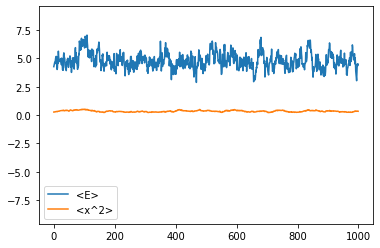

E_avg = 4.793583297680885, KE_avg = 4.653569164642091, PE_avg = 0.17047619863184932, x^2_avg = 0.12023851234681875


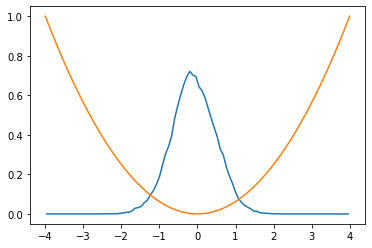

In [65]:
import matplotlib.pyplot as plt

plt.plot(E_collect,label = "<E>")
plt.ylim(2*E_avg*np.array((-1,1)))
plt.plot(x2_collect,label = "<x^2>")
plt.legend()
#plt.ylim((0,1))
plt.show()
print(f"E_avg = {E_avg}, KE_avg = {KE_avg}, PE_avg = {PE_avg}, x^2_avg = {x2_avg}")

horiz = np.linspace(xmin+bindx/2,xmax-bindx/2,nbins)

plt.plot(horiz,X_binned/sum(X_binned) / bindx)

plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin))
plt.show()


```
Configs that work:

tau = 1000
eps = 1
N = 1000

Don't work:

tau = 100
eps = 0.1
N = 1000 ( E_avg ~5)

tau = 10
eps = 0.1
N = 1000

tau = 500
eps = 0.5
N = 1000
```



In [18]:
E_std = np.sqrt(sum(abs(E_collect - E_avg)**2)/ len(E_collect))
print("E_std = ",E_std)

E_std =  0.228227703100353


In [14]:
TE = 2*np.pi / 0.5
TE

12.566370614359172

In [30]:
x = lambda t: abs(t - tau/2)
V = lambda x : x**2

# const_ke_coeff = m/(2*N*eps**2) #constant in front of the KE sum
# const_pe_coeff = 1/N            #constant in front of the PE sum
# E_new = (
#         #KE - use average displacement (wrap around since motion periodic)
#         const_ke_coeff*sum((x0 - np.roll(x0,1))**2)
#         #PE - use each point
#         +const_pe_coeff*sum(V(x0))
# )
tau = 10

eps = 1; N = round(tau/eps); x0 = x(np.linspace(0,tau,N+1)[:-1])
print(
    #KE - use average displacement (wrap around since motion periodic)
    1/(2*N*eps**2)*sum((x0 - np.roll(x0,1))**2)
    #PE - use each point
    +1/N*sum(V(x0))
)
eps = 0.1; N = round(tau/eps); x0 = x(np.linspace(0,tau,N+1)[:-1])
print(
    #KE - use average displacement (wrap around since motion periodic)
    1/(2*N*eps**2)*sum((x0 - np.roll(x0,1))**2)
    #PE - use each point
    +1/N*sum(V(x0))
)

eps = .01; N = round(tau/eps); x0 = x(np.linspace(0,tau,N+1)[:-1])
print(
     #KE - use average displacement (wrap around since motion periodic)
     1/(2*N*eps**2)*sum((x0 - np.roll(x0,1))**2)
     #PE - use each point
    +1/N*sum(V(x0))
)

#theoretical <x^2> (ground state)
eps = .01
N = 1000000
R = 1 + eps**2 - eps * np.sqrt(1 + eps / 4)
1 / (2*np.sqrt(1+ eps**2/4)) * ( ( 1+ R**N ) / (1 - R**N) )
print( "<x^2> = ", 1 / (2*np.sqrt(1+ eps**2/4)) * ( ( 1+ R**N ) / (1 - R**N) ))

9.0
8.835000000000003
8.83334999999999
<x^2> =  0.49999375011718505
